# How to scale Amplitudes in FFT calculated spectrum

In [148]:
# Copyright (C) 2020 Danny Schneider
##
## This program is free software; you can redistribute it and/or
## modify it under the terms of the GNU General Public
## License as published by the Free Software Foundation;
## either version 2, or (at your option) any later version.
##
## Octave is distributed in the hope that it will be useful,
## but WITHOUT ANY WARRANTY; without even the implied
## warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR
## PURPOSE.  See the GNU General Public License for more
## details.
##
## You should have received a copy of the GNU General Public
## License along with Octave; see the file COPYING.  If not,
## write to the Free Software Foundation, 59 Temple Place -
## Suite 330, Boston, MA 02111-1307, USA.

In [149]:
clear all;
close all;

In [150]:
fig=1;

## public functions

In [151]:
%%file my_normalize.m

function result=my_normalize(data,newmax)
  newmax=abs(newmax);                   # Remove sign of newmax
  signal_min=abs(min(data));            # Find absolut minimum
  signal_max=abs(max(data));            # Find absolut maximum
  factor=max([signal_min,signal_max]);  # choose scaling factor 
  result=(data .* newmax) ./ factor;    # scale the data
  return;
endfunction

In [152]:
%%file get_mean.m

function res=get_mean(data)
  res=0;
  div=length(data);
  for(ii=1:1:length(data))
    res = res .+ (data(ii)./div);
  endfor
  return;
endfunction

In [ ]:
%%file my_standarddeviation.m

function result = my_standarddeviation(data)
  ##Todo: check data to be 1dim
  nos = length(data);

  #mean = sum(data)./nos;
  mean = get_mean(data);
  tmp1 = (data.-mean).^2;
  tmp2 = sum(tmp1)./(nos.-1);

  result = sqrt(tmp2);
  result = my_precise_result(result);
  return;
endfunfction

the root-mean-square: DC equivalent of an AC Signal [data]

In [153]:
%%file my_rootmeansquare.m

function result=my_rootmeansquare(data)
  result = sqrt(sum(data.^2)/length(data));
  return;
endfunction

In [154]:
%%file tospectrum.m

function spectrum = tospectrum(timedomain_data)
  tmp = fft(timedomain_data);
  #(1,1:(length(timedomain_data)./2));
  noiseshift = -10*log(length(tmp));
  #noiseshift=0;
  spectrum = 20.*log(abs(tmp)) .+ noiseshift;
  return;
endfunction

Theoretical Noise Floor to best Signal

In [155]:
%%file snr_expected.m

function res = snr_expected(bits)
  res = 6.022*bits+1.76;
  return;
endfunction

Calculate position of hamonics

In [156]:
function pos = harmonic_pos_calc(nos,fs,fsig,harmonic)
  f1pos = nos./(fs./2.0).*fsig;
  vpos = f1pos.*(1.+harmonic);
  mirror = floor(vpos/nos);
  even = mod(mirror,2.0);
  rest = mod(vpos,nos);
  if(even==0)
    pos=round(rest);
  else
    pos=round(nos-rest);
  endif
  return;
endfunction

Estimate Amplitude of hamonic

In [157]:
function res=harmonic_extract(data,pos,noiseval)
  lpos=pos;
  rpos=pos;
  if(pos>0)
    if(pos<length(data))
      while(data(lpos)>noiseval)
        --lpos;
        if(lpos==0)
          break;
        endif
      endwhile    
      while(data(rpos)>noiseval)
        ++rpos;
        if(rpos==length(data))
          break;
        endif
      endwhile
    endif
  endif
   
  res = 0;
  scale=rpos.-lpos.+1;
  for(ii=lpos:1:rpos)
    res += data(ii)./scale;
  endfor
  return;
endfunction

Basic Constants

In [158]:
fs      = 100; #Sampling Frequency
Ts      = 1./fs; #Sampling period
fsig    = 2;   #Signal Frequency
periods = 10;    #Number of Periods
amp     = 1.5;   #Signal Amplitude
20.*log10(amp)   #Signal Amplitude in dB

ans =  3.5218


## time discrete sine
__infinite__ amplitude resolution

In [159]:
tend=periods./fsig;
nos = ceil(tend.*fs);
tend = nos./fs;
t=linspace(0,tend,nos);
y=amp.*sin(2.*pi().*t.*fsig);
rms=sqrt(sum((y.^2)./nos))
sig_power=y.^2;
sum(sig_power)./nos
max(sig_power)
mean=get_mean(y)


rms =  1.0596
ans =  1.1227
ans =  2.2500
mean =   -1.7432e-16


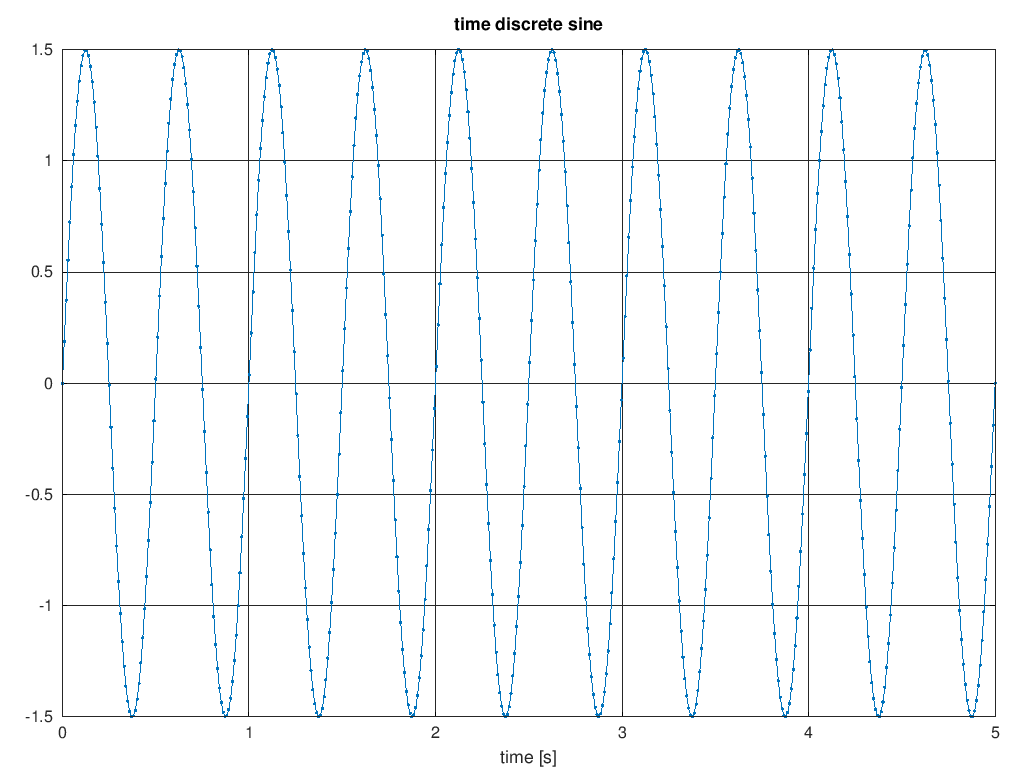

In [160]:
figure(fig++);
plot(t,y,"- .");
grid on;
title("time discrete sine");
xlabel("time [s]");

## sample Signal with a ideal ADC

In [161]:
span=range(y);
bits=5;
LSB=span./(2.^bits.-1);
dy=round((y.+(span./2))./LSB);
min(dy)
max(dy)
SNR=snr_expected(bits)
mean=get_mean(dy)

ans = 0
ans =  31
SNR =  31.870
mean =  15.500


## time discrete sine
discrete amplitude resolution

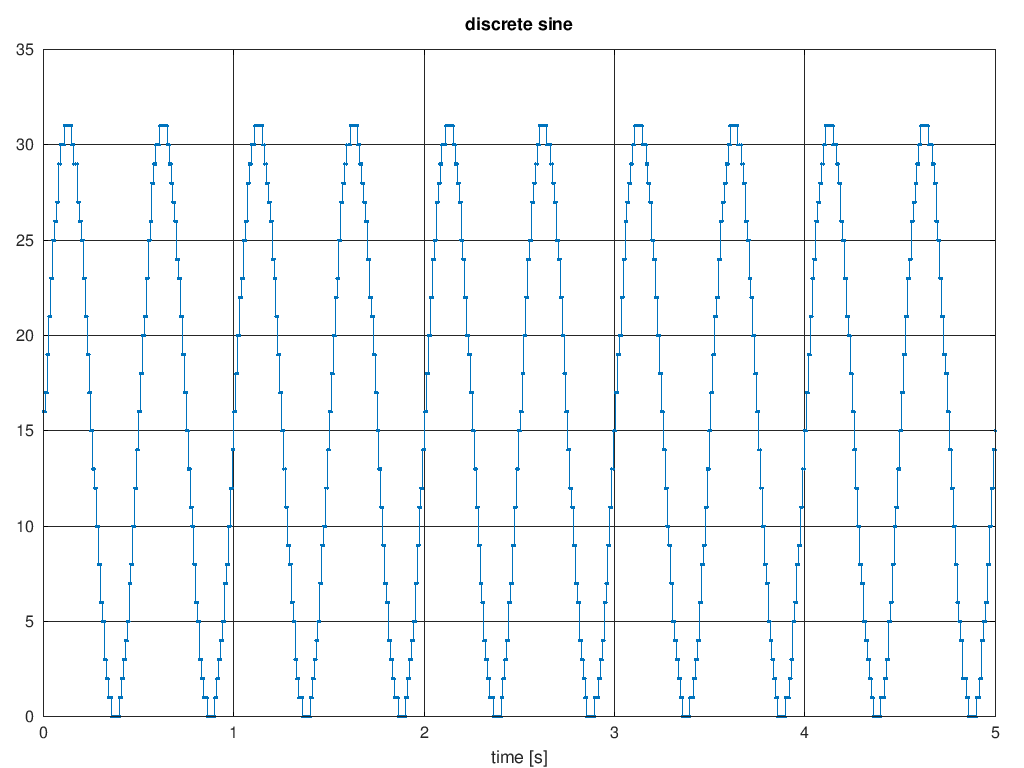

In [162]:
figure(fig++);
stairs(t,dy,"- .");
grid on;
title("discrete sine");
xlabel("time [s]");

## ADC alternate implementation

In [163]:
## usage: result=my_quantisize(data,bits_steps,asbits)
## Returns data quantisized with the given number of bits
function result=my_quantisize(data,bits_steps,asbits)
  if(asbits != 0)
    levels=2.^bits_steps;
  else
    levels=bits_steps;
  endif
  offset=1;
  span=range(data);
  %If all Samples have the same Value
  if(span==0)
    offset=0;
    %get absolut value of one Sample
    span=max(abs(data(1)));
    %If all Samples are zeros
    if(span==0)
      %no quantisation at all!
      result = data;
      return;
    endif
  endif
  lsb=span./(levels.-1);
  withoffset=round(data./lsb);
  if(offset==1)
      offset=min(withoffset);
  endif
  result=withoffset.-offset;
endfunction

In [164]:
dy=my_quantisize(y,bits,1);
min(dy)
max(dy)

ans = 0
ans =  32


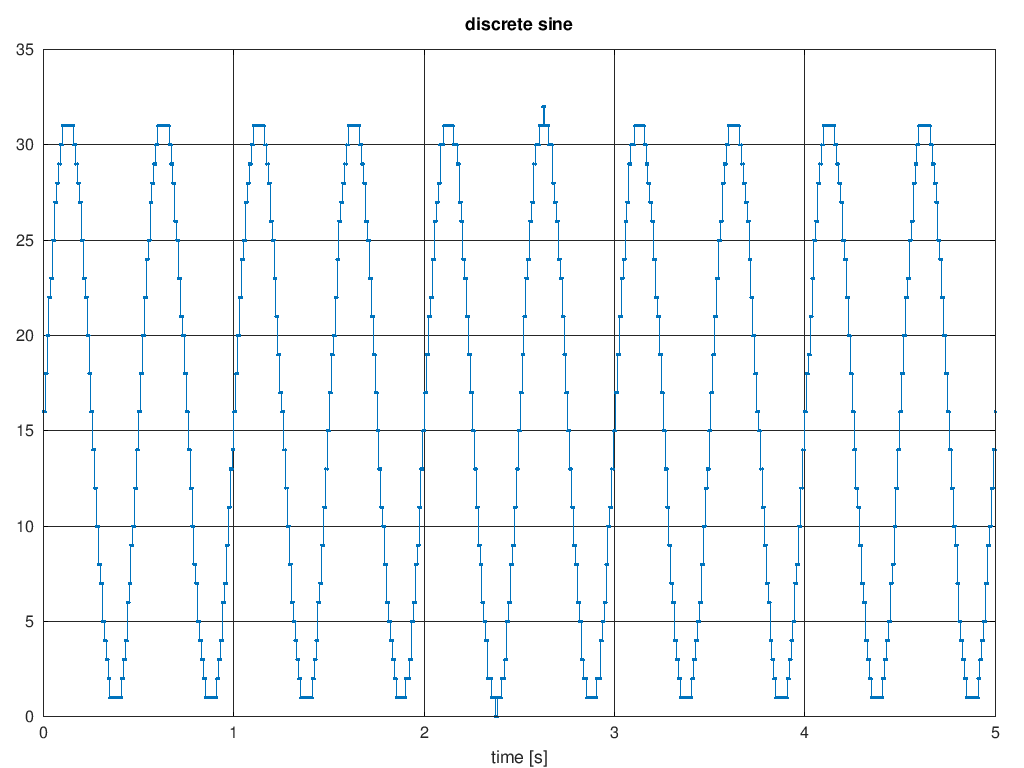

In [165]:
figure(fig++);
stairs(t,dy,"- .");
grid on;
title("discrete sine");
xlabel("time [s]");

## Zero Extend Signal-Length to power of 2

In [166]:
nos2=2^ceil(log2(nos));
znos=nos2.-nos;
ze=zeros(1,znos);
dy = [dy ze];

## spectrum

In [167]:
f=linspace(0,fs,nos2)(1:1:(nos2/2));
fmin=min(f)
fmax=max(f)
s=(2./nos2).*LSB.*abs(fft(dy)(1:1:(nos2/2)));
s(1)=0; #set DC to zero
s(2)=0;
s(3)=0;
max(s) 
#Get value of fundamental peak
lineresolution=fs./(2.*nos2)

fmin = 0
fmax =  49.902
ans =  1.3211
lineresolution =  0.097656


Positions of Harmonics

In [168]:
hpos=zeros(1,5);
for ii=1:1:length(hpos)
  hpos(:,ii)=harmonic_pos_calc(nos2,fs,fsig,ii.-1);
endfor
hpos

hpos =

    20    41    61    82   102



Extract Value / Amplitude of Harmonics

In [169]:
hamp=zeros(1,length(hpos));
for ii=1:1:length(hpos)
  hamp(:,ii)=harmonic_extract(s,hpos(:,ii),2.*LSB);
endfor
hamp

hamp =

   0.0639556   0.0048671   0.0162227   0.0041366   0.0097289



Plot of spectrum

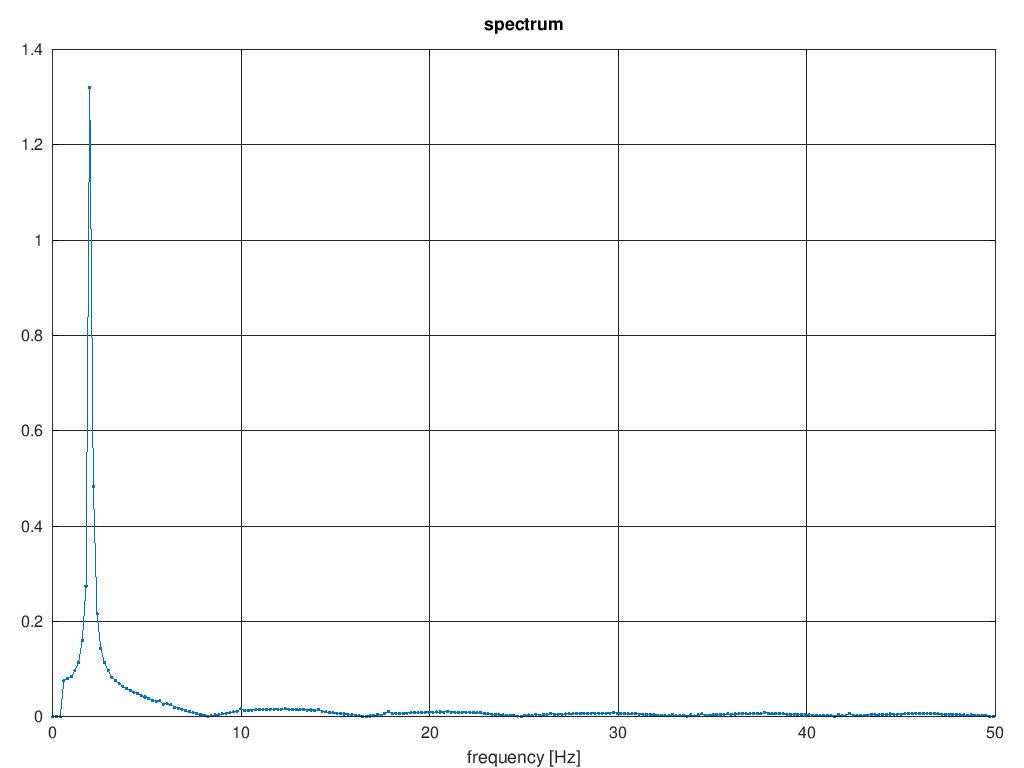

In [170]:
figure(fig++);
plot(f,s,"-d.");
grid on;
title("spectrum");
xlabel("frequency [Hz]");

## logarithmic scaled amplitude spectrum in dB

ans =  2.4184


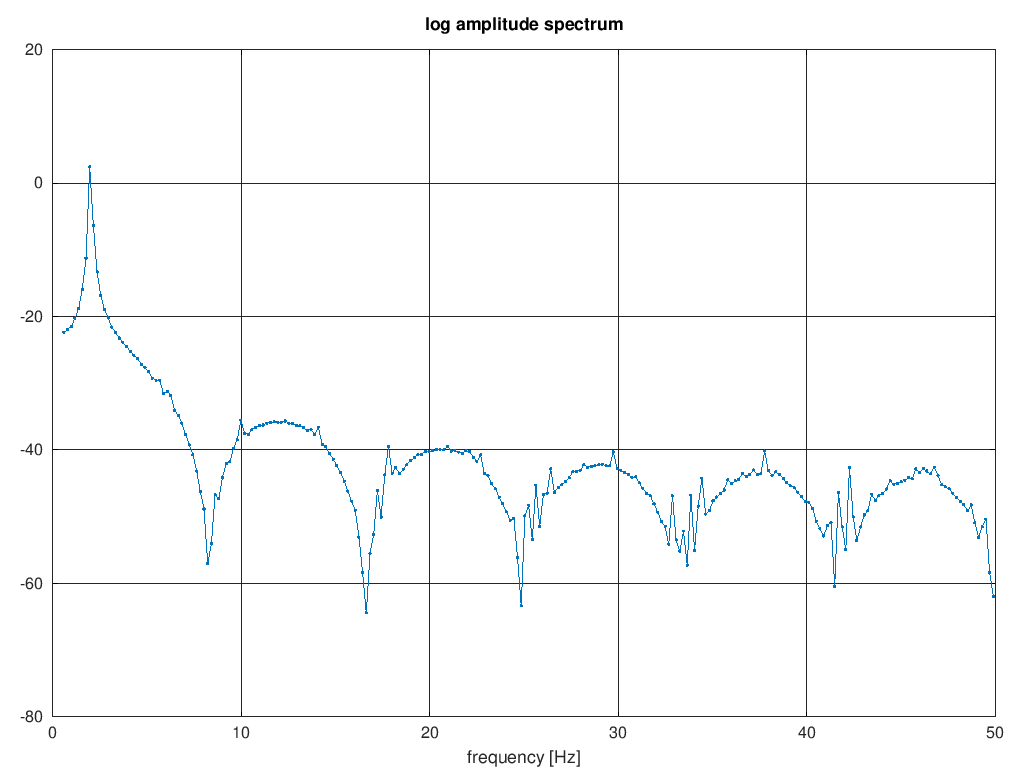

In [171]:
figure(fig++);
sl=20.*log10(s);
max(sl) #Get value of fundamental peak
plot(f,sl,"-d.");
grid on;
title("log amplitude spectrum");
xlabel("frequency [Hz]");

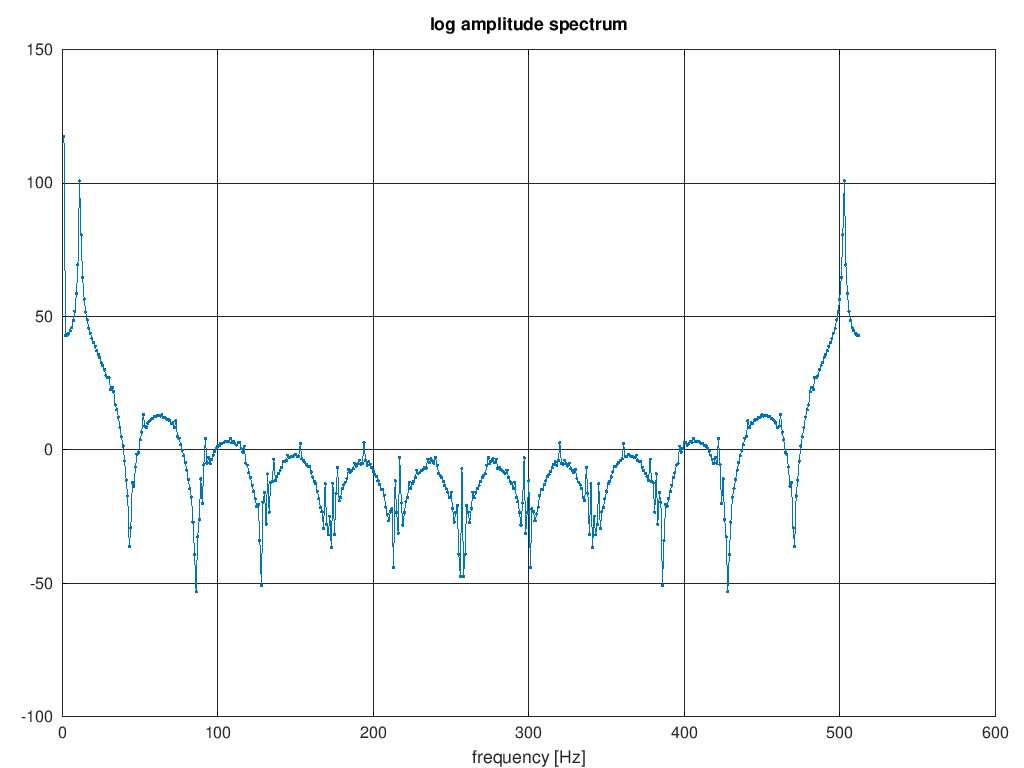

In [172]:
figure(fig++);
plot(tospectrum(dy),"-d.");
grid on;
title("log amplitude spectrum");
xlabel("frequency [Hz]");

## Window Function

In [173]:
w_hann=0.5*(1-cos(2*pi*(0:1:(nos2-1))/(nos2-1)));
CPG_Hanning=(1./nos2.*sum(w_hann)).^2

CPG_Hanning =  0.24902


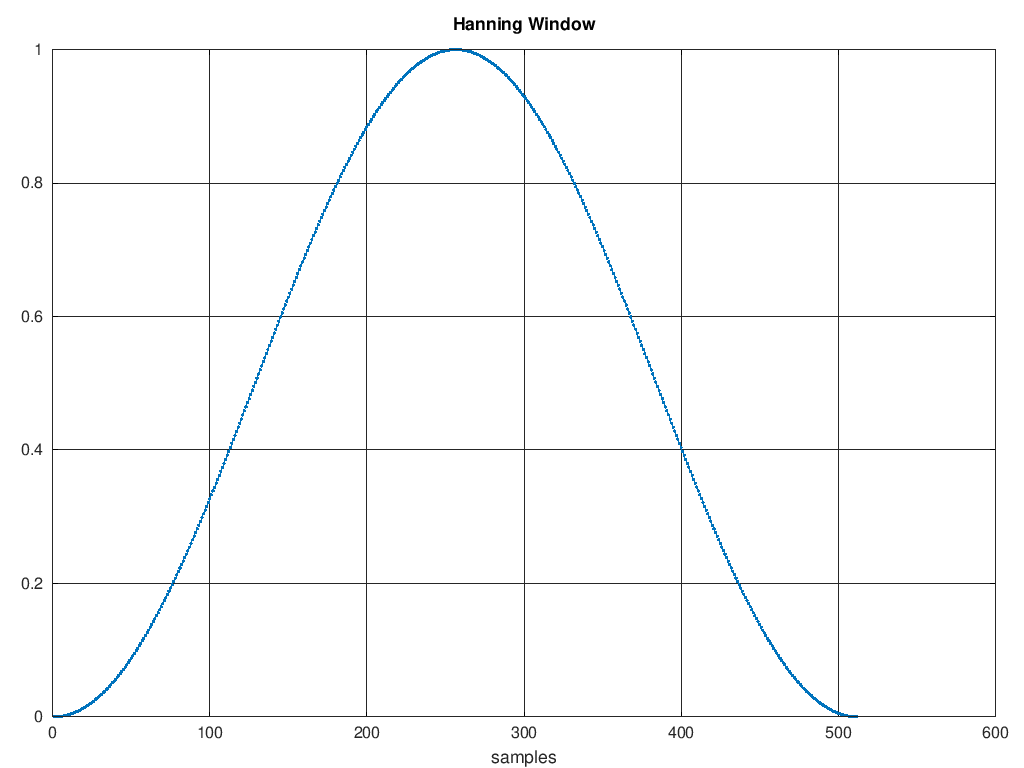

In [174]:
figure(fig++);
plot(w_hann,"-d.");
grid on;
title("Hanning Window");
xlabel("samples");

In [175]:
w_hann_unsym = 0.5.*w_hann.+0.5;

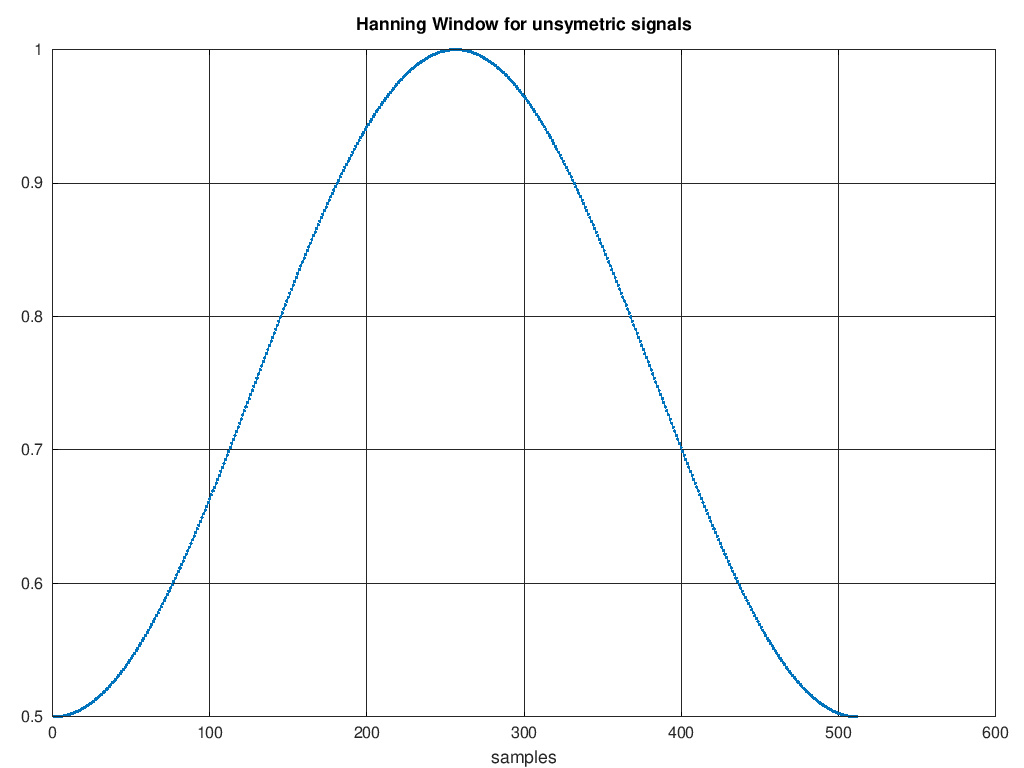

In [176]:
figure(fig++);
plot(w_hann_unsym,"-d.");
grid on;
title("Hanning Window for unsymetric signals");
xlabel("samples");

In [184]:
dz=(0.5.*(1.-w_hann));

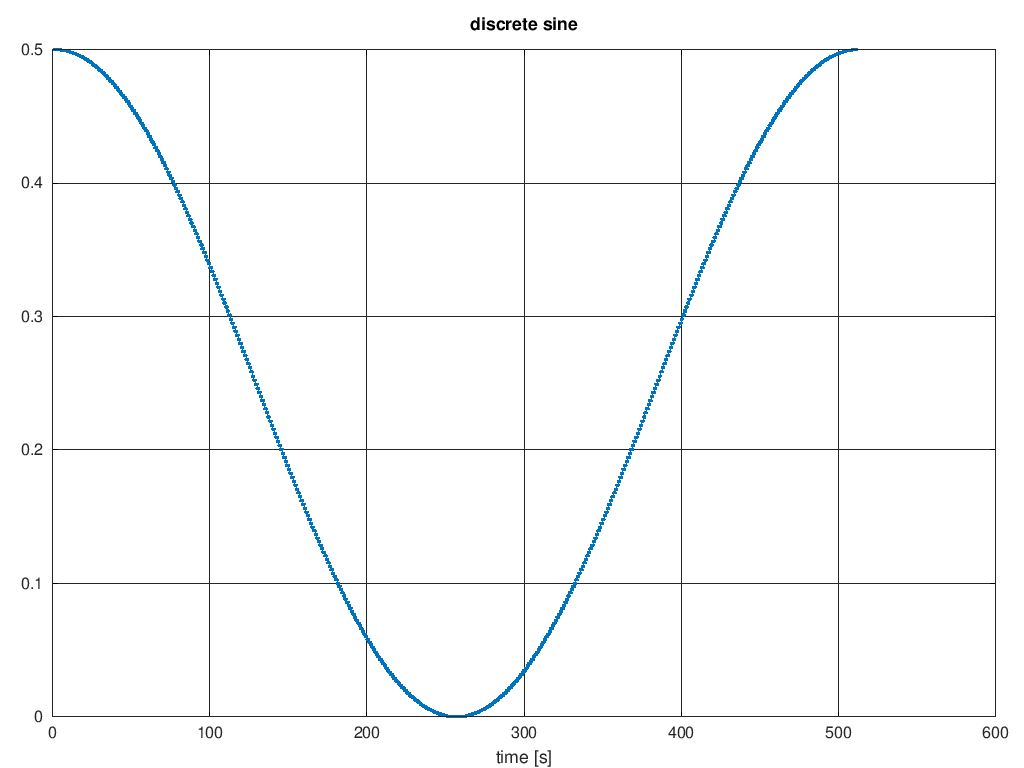

In [185]:
figure(fig++);
stairs(dz,"- .");
grid on;
title("discrete sine");
xlabel("time [s]");